# GSE GenAI TalkMoves Analysis

**Author:** Michael Spencer

**Purpose:** Explore classroom transcript data from the [TalkMoves repo](https://github.com/SumnerLab/TalkMoves) and performs NLP based analysis.

## Instructions

**Objective:** Evaluate your familiarity with NLP methods, especially in transforming unstructured text data
into structured form.

**Task Overview:** For this section of the data task, you will use NLP methods to process transcript data from classroom recordings and perform a focused exploratory analysis. Submit your code for this portion of the task as a Jupyter Notebook or Google Colab file, and remember to annotate your steps.

**Expected Working Time:** 3 hours or less

**Step-by-Step Instructions:**
1. Data Preparation and Description
  - Download the data folder from the TalkMoves repository on GitHub. You will use the metadata file “Datasheet for Public Release.xlsx” and the transcripts in the folder “Subset 2.”
  - Describe the data using information from the metadata.
  - Create a table summarizing the metadata (Tab “Subset 2” of “Datasheet for Public Release.xlsx”) with the following statistics:
    - Number of lessons transcribed (for the entire sample).
    - % of female teachers (for the entire sample).
    - % of lessons from middle school (for the entire sample).
2. Exploratory Text Analysis
- Explore the transcript files to familiarize yourself with the text data in these files.
- Summarize the contents of the transcripts briefly (2-3 sentences).
- Preprocess the text data (e.g., lowercasing, removing stopwords). Explain your preprocessing steps briefly (2-3 sentences).
3. Focused NLP Analysis
- Compute and visualize the top 10 words used by teachers across all transcripts.
- Create a histogram of the share of utterances per transcript attributed to the teacher.
4. Documentation and Submission
- Document your process, including any challenges faced and how you addressed them.
- Submit your Jupyter Notebook or Google Colab file with all code, visualizations, and commentary included.

**Evaluation Criteria**
- Technical Proficiency: Accuracy and efficiency of data preparation and text processing steps.
- Data Insight: Relevance and clarity of the analysis, including visualizations and summaries.
- Documentation: Clarity and thoroughness of the process documentation.

## Summary of Work

### Findings

The following serves as a quick reference summary of the key findings from this analysis per the questions posed in the instructions. Additional context, tables and visualizations are further down in the notebook.

**From the metadata file**
- There are 376 lessons transcribed
- The included teachers are 86% female (18 of the 21 for which I have transcripts)
- 27% of the lessons are from middle school (i.e. 6th 8th grade)

**From the NLP Analysis**
- The top 10 words used by teachers appear largely instruction and direction oriented and include words such as: "one", "okay", "going", "right" and "two"
- Teachers are responsible for the majority (~82%) of utterances in the transcripts, reflective of their authoritative and instructional position in the classroom.

### Challenges

The following quickly summarizes some of the largest challenges I faced while doing this analysis. More details are in the relevant sections below.

- **Metadata Naming Anomaly**
  - While exploring the metadata, I noticed some naming inconsistencies between what was listed in the metadata and what the files were actually called. This seemed to be due to how some recordings were split into multiple parts. I decided to count all files as their own unique lessons since I was unable to confirm how or why the lessons were split. It seemed reasonable that this was done due to breaks in instruction or context switching.
- **Sentence Field Type Discrepancy**
  - When loading the transcript files, I assumed that all values in the `Sentence` column would be strings. After recieving an error when using a function later on, I realized that a small handful of values had been coded as integers, booleans, etc., due to some utterances being numbers, fractions or affirmative statements such as "True". I cast the column to be a string type to avoid this error.

## Setup

### Libraries

In [44]:
# Environment libraries
from pathlib import Path

# Analysis libraries
import pandas as pd
import nltk
import re # For text cleaning
from nltk.corpus import stopwords

# Visualization libraries
from plotnine import *
from mizani.formatters import *

### Variables

In [45]:
# Filepaths
project_root = str(Path.cwd().resolve().parent)
path_metadata = project_root + "/data/Datasheet for Public Release.xlsx"
path_transcript_files = project_root + "/data/Subset 2/"

## Analysis

### 1. Data Preparation and Description

#### Downloading the data
To download the data from the [TalkMoves repo](https://github.com/SumnerLab/TalkMoves/tree/main), I downloaded the repo and moved the data folder into my own within this project @ `~/part2_nlp/data`

#### Metadata Description
I used Microsoft Excel to open and quickly explore the metadata file `Datasheet for Public Release.xlsx`. 

Based on the `Subset 2` metadata, the included transcripts were recorded:
- Over the course of about 2 academic years from October 2019 to August 2021. This roughly corresponds to the AY19-20 and AY20-21 school year.
- In 4th grade, 5th grade, middle, and high school classrooms.
- In classrooms predominantly taught by female teachers.
- Exclusively in English.

We can now load in the data and quantify some of these stats.

Note: I had to install a dependency here `pip install openpyxl` to open excel files. I added it to the `requirements.txt` file.

In [46]:
# Load in `Subsets 2` sheet of the `Datasheet for Public Release.xlsx` file
df_metadata = (pd.read_excel(path_metadata, sheet_name = "Subset 2")
                 .rename(columns = {
                    "Teacher ": "teacher",
                    "Lesson Title": "lesson_title",
                    "Date Recorded": "date_recorded",
                    "Year 1, Year 2": "year",
                    "Teacher Male/Female": "teacher_sex",
                    "Grade (exact grade or elementary, middle, high school)": "grade",
                    "Full or Partial Lesson": "lesson_length",
                    "Country, State": "country_state",
                    "Original Language": "original_language"
                }))

print(f"Metadata rows and columns: {df_metadata.shape}")
df_metadata.head()

Metadata rows and columns: (376, 9)


,teacher,lesson_title,date_recorded,year,teacher_sex,grade,lesson_length,country_state,original_language
0,Amelia Travers,TalkBack.Year1.Travers.Spring.010920,2020-01-09,Year 1,Female,4th & 5th,Full,"US, CO",English
1,Amelia Travers,TalkBack.Year1.Travers.Spring.011020,2020-01-10,Year 1,Female,4th & 5th,Partial,"US, CO",English
2,Amelia Travers,TalkBack.Year1.Travers.Spring.012220,2020-01-22,Year 1,Female,4th & 5th,Full,"US, CO",English
3,Amelia Travers,TalkBack.Year1.Travers.Spring.012720,2020-01-27,Year 1,Female,4th & 5th,Partial,"US, CO",English
4,Amelia Travers,TalkBack.Year1.Travers.Spring.012920,2020-01-29,Year 1,Female,4th & 5th,Full,"US, CO",English


When looking at the excel, I didn't notice duplicates, but let's check to confirm.

In [47]:
# Identify duplicate lesson titles
df_metadata[df_metadata.duplicated(subset="lesson_title")]

,teacher,lesson_title,date_recorded,year,teacher_sex,grade,lesson_length,country_state,original_language
28,Brenda Davies,TalkBack.Year2.Davies.Spring.012721-1,2021-01-27,Year 2,Female,MS,Full,"US, CO",English
123,Lisa Saunders,TalkBack.Year1.Saunders.Spring.020320-1,2020-02-03,Year 1,Female,HS,Full,"US, CO",English
230,Rebecca Cornish,TalkBack.Year2.Cornish.Fall.120920-1,2020-12-09,Year 2,Female,4th,Partial,"US, CO",English
364,Viola Strathom,TalkBack.Year2.Strathom.Spring.021821,2021-02-26,Year 2,Female,5th,Full,"US, CO",English


There appear to be four lessons duplicated, so I'm going to look at the correponding transcript files to see if it's an issue in the raw data as well, or just the metadata.


##### Challenge Note: Metadata Naming Anomaly
Looking at the raw files, there appear to be some naming discrepancies between the metadata files and the actual files. In some cases, the metadata lists a lesson as being in two parts despite the raw transcript only being one file. For example: `TalkBack.Year2.Davies.Spring.012721` is actually comprised of 2 parts, `TalkBack.Year2.Davies.Spring.012721-1` (which is in the metadata) and `TalkBack.Year2.Davies.Spring.012721-2` (which is not listed in the metadata).

In other cases, the opposite is true, where the raw transcripts contains multiple files per lesson but the metadata lists only one file. For example: `TalkBack.Year1.Carter.Fall.121119` only has one part listed in the metadata `TalkBack.Year1.Carter.Fall.121119-1` whereas the raw files contain both a part 1 and part 2.

It's hard to know what caused this discrepancy, but it appears that there are the same number of lessons in the metadata as are in the raw transcript files (376). **Thus, I'm going to treat each line in the metadata as an individual lesson. Notably, this asssumes that lessons split into two parts are distinct lessons.**

#### Metadata Summary
I will calculate the following stats from the metadata file:
- Number of lessons transcribed (for the entire sample).
  - Here I assume that each row in the metadata is a unique lesson. Given the naming convention, it's difficult to know whether a teacher taught multiple lessons on the same date. This is a simplifying assumption.
- % of female teachers (for the entire sample).
  - I'm interpetting this to be the % of female teachers of all teachers rather than "The % of transcripts attributed to a female teacher."
- % of lessons from middle school (for the entire sample).
  - I include grade 6 in middle school, along with the "MS" grade designation.

These stats will reflect the transcript data as reflected in the *metadata file*, which may be slightly off given the discrepancies noted above. I'm okay with this given that the instructions state to use the metadata file and I don't expect the discrapency to be large.

In [48]:
num_lessons = len(df_metadata)

# Assumes no teacher names are duplicated, but this is a reasonable assumption given the sample size
num_teachers = len(df_metadata.filter(["teacher"]).drop_duplicates())
num_female_teachers = len(df_metadata.query('teacher_sex == "Female"').filter(["teacher"]).drop_duplicates())
pct_female_teachers = num_female_teachers / num_teachers

num_ms_lessons = len(df_metadata.query('grade == "MS" or grade == "6th"'))
pct_ms_lessons = num_ms_lessons / num_lessons

# Create a formatted table
summary_data = {
    "Statistic": ["Number of lessons transcribed:", "% of included teachers that are female:", "% of lessons from middle school:"],
    "Value": [num_lessons, f"{round(100 * pct_female_teachers)}% (i.e. {num_female_teachers} of {num_teachers})", f"{round(100 * pct_ms_lessons)}% (i.e. {num_ms_lessons} of {num_lessons})"]
}

df_metadata_summary = pd.DataFrame(summary_data)
print(df_metadata_summary)

                                 Statistic                  Value
0           Number of lessons transcribed:                    376
1  % of included teachers that are female:    86% (i.e. 18 of 21)
2         % of lessons from middle school:  27% (i.e. 103 of 376)


### 2. Exploratory Text Analysis

#### Data Exploration and Transcript Content Description

From a brief look in excel, the transcript files contain speech from classroom lessons parsed into utterances (sentences). The files contain the following for each utterance: a timestamp, the speaking turn, the speaker, the sentence/utterance spoken and the codified [TalkMoves tag](https://github.com/SumnerLab/TalkMoves/blob/main/Coding%20Manual.pdf) for either the teacher or student depending on who spoke. Notably, not all transcripts use a consistent flag for the teacher in the "Speaker" column, so I will make the simplifying assumption that the presence of a `Teacher Tag` indicates the teacher spoke and will use that to assign utterances to teachers vs students in later parts of this analysis.

#### Loading the Transcript Data
Given the structure of the transcripts and our goal, for each transcript, I will do the following:
- Read it in using pandas and extract only the sentence and teacher tag columns to avoid any added table columns causing an error
- Tag it with a unique ID to identify each transcript

Using the above, I will create a new working dataframe from which to tokenize and analyze the data.

I have checked to confirm that there are no duplicate files in the data.

In [49]:
# Iteratively read in the xlsx files in the `data/Subset 2` folder
excel_files = list(Path(path_transcript_files).glob("*.xlsx"))

print(f"Attempting to load {len(excel_files)} transcripts.")

# Read and combine the Excel files
index_num = 1
all_dfs = []
for file in excel_files:
    try:
        df_excel = pd.read_excel(file).filter(["Sentence", "Teacher Tag"])
        df_excel["transcript_num"] = index_num
        index_num += 1
        all_dfs.append(df_excel)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Combines all the loaded dataframes (transcripts) into one for analysis
df_all_transcripts = pd.concat(all_dfs, ignore_index=True)

del all_dfs

print(f"Loaded {index_num - 1} transcripts.")

Attempting to load 376 transcripts.
Loaded 376 transcripts.


In [50]:
print(f"It appears we have {df_all_transcripts.shape[0]} utterances in the data. I'll now quickly check for null utterances in the data and remove them.")

It appears we have 181245 utterances in the data. I'll now quickly check for null utterances in the data and remove them.


In [51]:
# Filter to rows with missing values in the sentence column
print(f"There are {df_all_transcripts["Sentence"].isnull().sum()} rows with missing values in the sentence column.")

There are 8 rows with missing values in the sentence column.


This is a tiny fraction of data, so removing them should have no discernible effect on our results.

In [52]:
# Remove rows where the sentence is missing
df_all_transcripts = df_all_transcripts.dropna(subset=["Sentence"])

In [53]:
df_all_transcripts.shape[0]

181237

#### Data Cleaning and Processing Steps

For the tokenization work, we're only interested in identifying the top 10 words used by **teachers**, meaning I can go ahead and filter out utterances by students in the table above. I will prep the data for text analysis by extracting it from the dataframe, lowercasing it, removing punctuation and digits with the `re` package, tokenizing it with `NLTK`, and removing stopwords using `NLTK`'s stopwords set. Future work could further process the text by lemmatizing the words and considering additional context specific stopwords to remove.

In [54]:
# Filter out rows with null teacher tags (i.e. student utterances)

df_teacher_utterances = df_all_transcripts.dropna(subset=["Teacher Tag"])

filtered_out_count = df_all_transcripts.shape[0] - df_teacher_utterances.shape[0]
filtered_out_pct = round(100 * (filtered_out_count / df_all_transcripts.shape[0]), 2)

print(f"This filtered out {filtered_out_count} student utterances, roughly {filtered_out_pct}% of all utterances in the data.")

This filtered out 32011 student utterances, roughly 17.66% of all utterances in the data.


##### Challenge Note: Sentence Field Type Discrepancy
In my first attempt at cleaning the data and concatenating the utterances in the `Sentence` field I ran into an error since some utterances (~570) were loaded in as a different data type (i.e. ints, floats, datetimes, etc.). Puzzled, I took another look at the transcripts and realized that some utterances were indeed numbers or fractions, often in response to math questions. Since this isn't an error in the data, I manually cast the type to a string below, allowing me to continue.

In [55]:
# Extract the sentences and ensure all are strings
teacher_utterances = df_teacher_utterances["Sentence"].astype(str)
teacher_corpus = teacher_utterances.str.cat(sep=' ')

In [56]:
# Lowercase text and remove punctuation and digits
teacher_corpus = re.sub(r'[^a-zA-Z\s]', '', teacher_corpus.lower())

# Tokenize the corpus and remove stopwords
stopwords = stopwords.words('english')
tokenized_corpus = nltk.word_tokenize(teacher_corpus, language = 'english', preserve_line = True)
cleaned_corpus = [token for token in tokenized_corpus if token not in stopwords]

In [57]:
cleaned_corpus[:10]

['right',
 'thats',
 'working',
 'know',
 'successful',
 'use',
 'drawings',
 'fraction',
 'circle',
 'pieces']

### 3. Focused NLP Analysis

#### Calculate and Visualize Top 10 Words Used by Teachers
Here I use `NLTK.FreqDist` function and `pandas` to calculate top 10 words used by teachers and `plotnine` to create visualizations. I use `plotnine` here due to my own familiarity with R's `ggplot`.

In [58]:
# Count individual word frequencies
word_freq = nltk.FreqDist(cleaned_corpus)

# Convert to DataFrame and take the top 10 words
data_word_freq = (pd.DataFrame(word_freq.items(), columns = ["word", "count"])
                    .sort_values(by = 'count', ascending = False))

data_word_freq.head(10)

,word,count
62,one,14090
51,okay,13277
20,going,12554
0,right,9634
12,two,8787
104,three,6222
52,im,6082
30,youre,5720
57,go,5598
121,would,5334


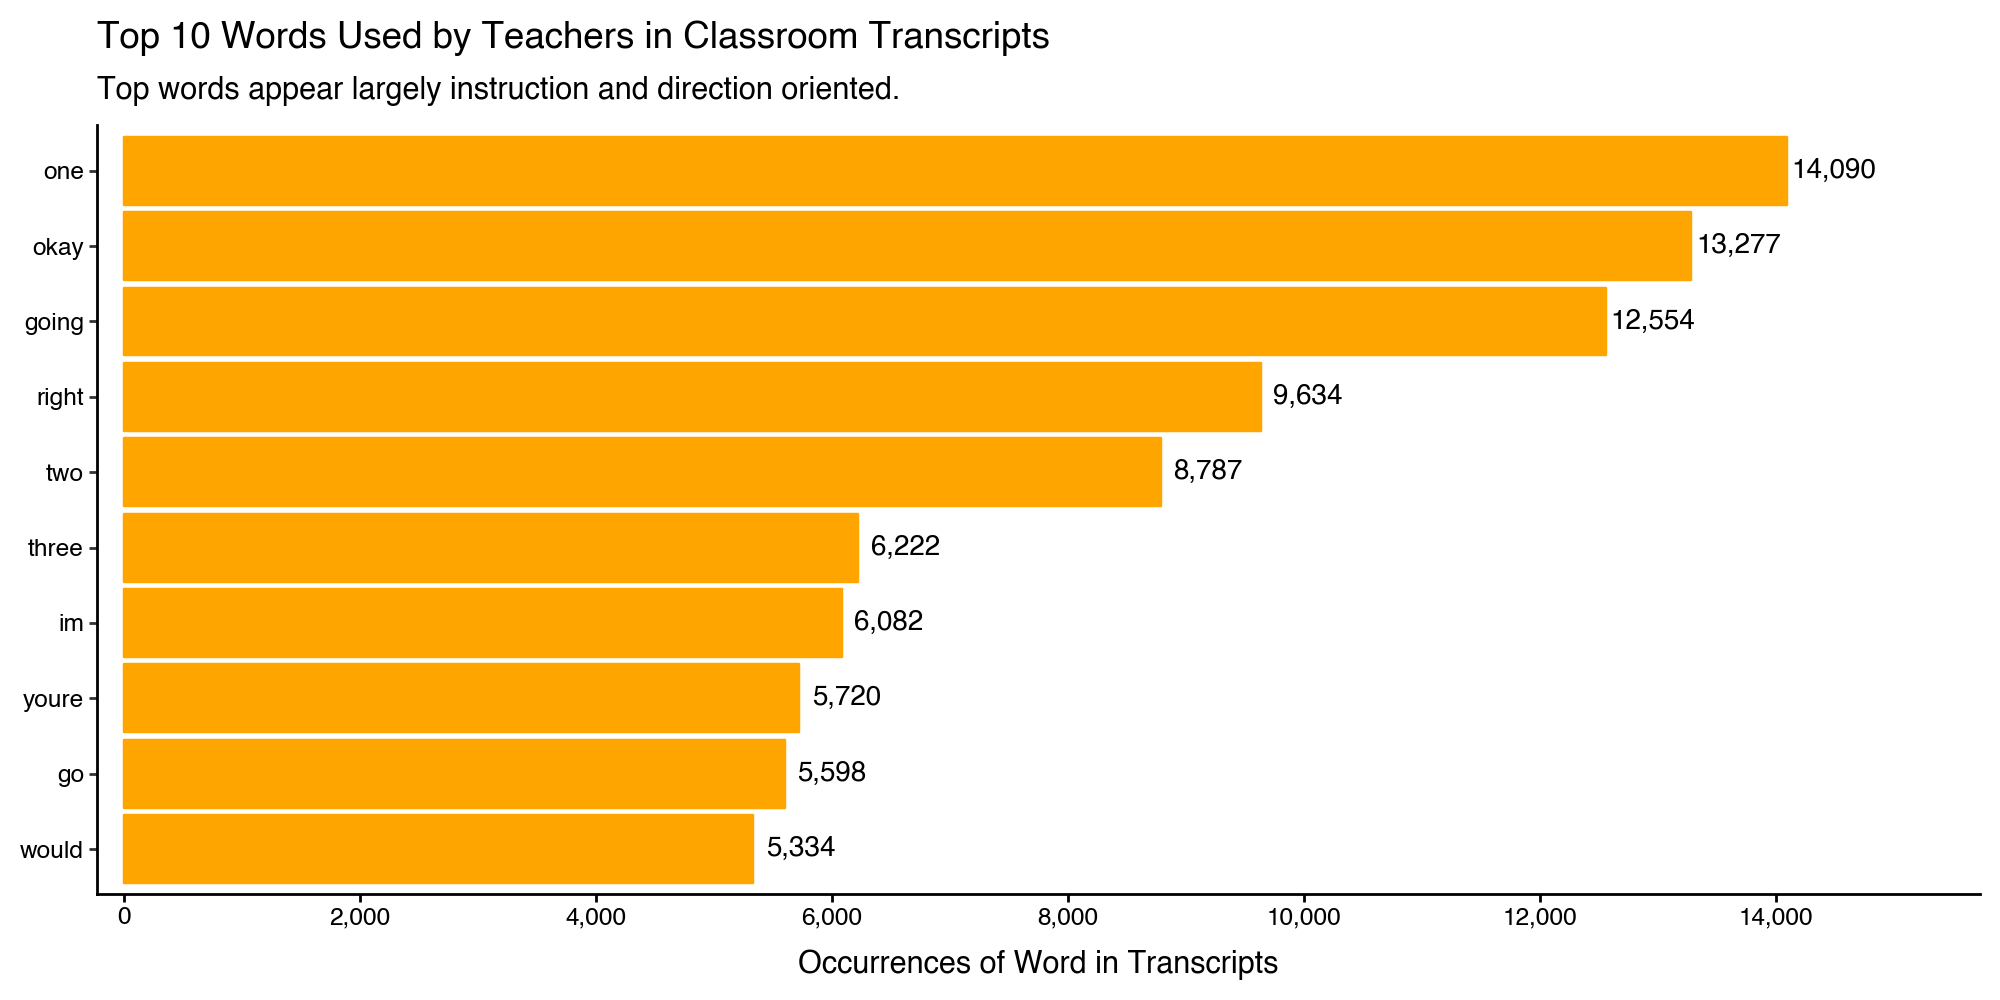

In [59]:
# Visualize top 10 words used by teachers
(ggplot(data_word_freq.head(10), aes(x = 'reorder(word, count)', y = 'count')) +
 geom_col(fill = 'orange', color = 'orange') +
 geom_text(
    aes(label = 'count'),
    format_string = '{:,}',
    nudge_y = 400,
    size = 10
 ) +
 labs(
    title = "Top 10 Words Used by Teachers in Classroom Transcripts",
    subtitle = "Top words appear largely instruction and direction oriented.",
    x = "",
    y = "Occurrences of Word in Transcripts"
 ) +
 coord_flip(ylim = [500, 15000]) +
 scale_y_continuous(breaks = range(0, 15000, 2000), labels = comma_format()) +
 theme(
    panel_background = element_blank(),
    panel_grid_major = element_blank(),
    axis_ticks_major_x = element_text(color = "black"),
    axis_line = element_line(color = "black", size = 1),
    text = element_text(color = "black"),
    figure_size = [10, 5]
 ))

The top 10 words used by teachers appear lagely instruction and direction oriented:
- "One", "two", or "three" could be used in the context of describing steps or counting down to gather student's attention.
- "Okay" and "right" could be used in the affirmative or to move students' forward in their thinking.
- "Going" and "go" could be directives while describing an assignment.
- "I'm" and "you're" define an actor, stating who will take part in the described task.

#### Visualize the Share of Utterances per Transcript Attributed to Teachers

In [60]:
# Calculate utterances per teacher by determining the % of utterances in each transcript
df_all_transcripts["is_teacher"] = df_all_transcripts["Teacher Tag"].notnull()

df_pct_utterances_by_teacher = (
    df_all_transcripts.value_counts(["transcript_num", "is_teacher"])
                      .reset_index(name = 'cnt')
                      .sort_values(by = 'transcript_num')
                      .pivot(index = 'transcript_num', columns = 'is_teacher', values = 'cnt')
                      .assign(pct_teacher = lambda x: x[True] / (x[True] + x[False]))
                      .filter(["transcript_num", "pct_teacher"])
                      .reset_index()
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 2 rows containing non-finite values.


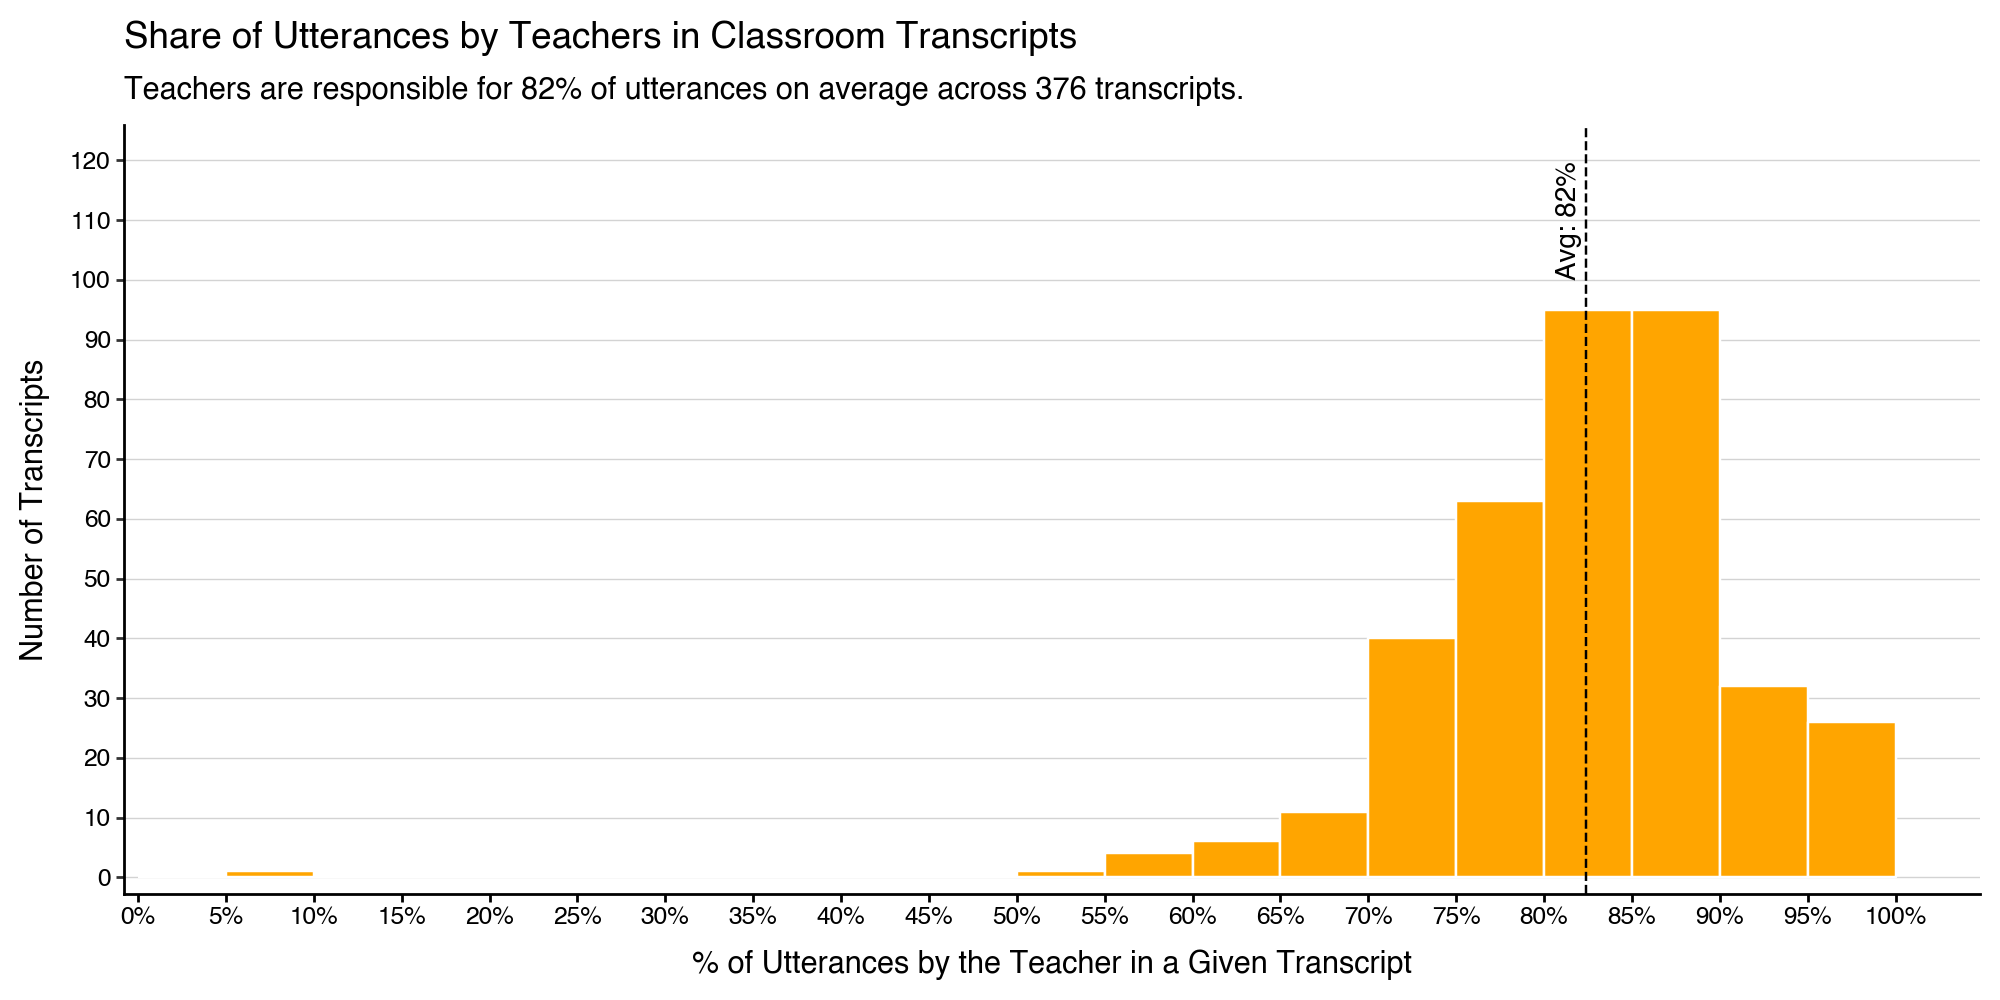

In [61]:
# Visualize the % of utterances per teacher as a histogram
avg_pct = df_pct_utterances_by_teacher["pct_teacher"].mean()

# Manually calculates the x-axis range for the sake of making the chart look better.
x_range = [i / 100 for i in range(0, 101, 5)]

(ggplot(df_pct_utterances_by_teacher, aes(x = 'pct_teacher')) +
 geom_histogram(fill = 'orange', color = 'white', breaks = x_range) +
 geom_vline(xintercept = avg_pct, linetype = 'dashed', color = 'black') +
 labs(
    title = "Share of Utterances by Teachers in Classroom Transcripts",
    subtitle = f"Teachers are responsible for {int(round(100 * avg_pct, 0))}% of utterances on average across {index_num - 1} transcripts.",
    x = "% of Utterances by the Teacher in a Given Transcript",
    y = "Number of Transcripts"
 ) +

 # Annotates the average percentage of teacher utterances for clarity
 annotate("text", x = avg_pct - .01, y = 110, label = f"Avg: {int(round(100 * avg_pct, 0))}%", color = "black", angle = 90, size = 10) +
 scale_x_continuous(breaks = [i / 100 for i in range(0, 101, 5)], labels = percent_format()) +
 scale_y_continuous(breaks = range(0, 130, 10), labels = comma_format()) +
 
 # Does not alter the data but improves the visuals by reducing awkward gaps
 coord_cartesian(xlim = [.04, 1], ylim = [3, 120]) +
 theme(
    panel_background = element_blank(),
    panel_grid_major_x = element_blank(),
    panel_grid_major_y = element_line(color = "lightgray", size = 0.5),
    axis_ticks_major_x = element_text(color = "black"),
    axis_line = element_line(color = "black", size = 1),
    text = element_text(color = "black"),
    figure_size = [10, 5]
 ))

Teachers are responsible for the majority of utterances in the transcripts. This isn't too surprising, given their role in the classroom as authority and instructional figures, whose job it is to deliver directions and manage student behavior. There is one notable outlier, wherein the teacher only acounted for 5-10% of the utterances in the transcript. It's likely this was a recording error or partial transcript.